In [5]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from topostats.io import LoadScans
import topostats.filters as topofilters
from topostats.utils import get_mask
from scipy.optimize import least_squares
from scipy.interpolate import splprep, splev
from scipy.spatial import distance
from skimage.filters import gaussian
from skimage.filters import threshold_otsu
from skimage.morphology import binary_erosion
from scipy import ndimage
from scipy.spatial.distance import cdist
from skimage.morphology import label
from skimage.draw import disk
import csv

import network_stats as ns

In [6]:
def plot(image: np.ndarray, title=None, zlimit=True, **kwargs) -> None:
    fig, ax = plt.subplots(figsize=(8, 8))
    if zlimit == True:
        vmin=-3
        vmax=4
    else:
        vmin=None
        vmax=None
    ax.imshow(image, vmin=vmin, vmax=vmax, **kwargs)
    if title is not None:
        ax.set_title(title)
    plt.show()

[Tue, 12 Dec 2023 20:38:34] [INFO    ] [topostats] Extracting image from EcoPst\20230406_EPN001_BlackTeflon_Standard.0_00005.spm
[Tue, 12 Dec 2023 20:38:34] [INFO    ] [topostats] Loading image from : EcoPst\20230406_EPN001_BlackTeflon_Standard.0_00005.spm
[Tue, 12 Dec 2023 20:38:34] [INFO    ] [topostats] [20230406_EPN001_BlackTeflon_Standard.0_00005] : Loaded image from : EcoPst\20230406_EPN001_BlackTeflon_Standard.0_00005.spm
[Tue, 12 Dec 2023 20:38:35] [INFO    ] [topostats] [20230406_EPN001_BlackTeflon_Standard.0_00005] : Extracted channel Height
[Tue, 12 Dec 2023 20:38:35] [INFO    ] [topostats] [20230406_EPN001_BlackTeflon_Standard.0_00005] : Pixel to nm scaling : 4.638671875


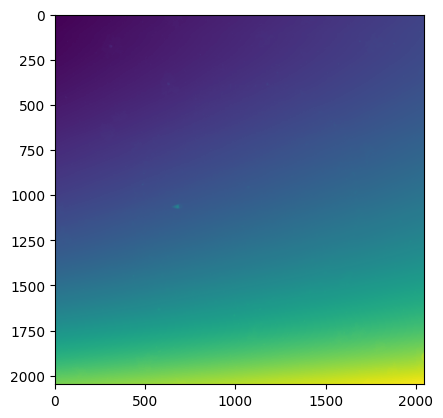

In [7]:
#Flat
FILE_DIR = Path('/Users/sylvi/topo_data/Bradley/Flat/')
#Pristine
#file = Path('./Flat/20221213_KDNA001.0_00020.spm')
#file = Path('./flat/20230118_KPN001.0_00005.spm') Bad qual
#file = Path('./Flat/20230118_KPN001.0_00011.spm')
#file = Path('./Flat/20230118_KPN001.0_00023.spm')
#file = Path('./flat/20230125_KPN005.0_00006.spm') Bad qual
#file = Path('./flat/20230125_KPN005.0_00028.spm')
#file = Path('./flat/20230126_KPN005.0_00004.spm')
#file = Path('./flat/20230126_KPN005.0_00013.spm')
#file = Path('./flat/20230126_KPN005.0_00019.spm')
#file = Path('./flat/20230126_KPN005.0_00024.spm')
#file = Path('./flat/20230217_KPN010.0_00010.spm')
#file = Path('./flat/20230314_KPN015.0_00016.spm')
#file = Path('./flat/20230417_KPN0018.0_00000.spm')
#file = Path('./flat/20230417_KPN0018.0_00002.spm') 
#EcoPst
file = Path('./EcoPst/20230406_EPN001_BlackTeflon_Standard.0_00005.spm')

loadscans = LoadScans([file], 'Height')
loadscans.get_data()
p_to_nm = loadscans.pixel_to_nm_scaling
image_raw = loadscans.image
plt.imshow(image_raw)

In [8]:
#Parameters
Rosette_Thres = 1.25
Gauss_Min_Size = 60
Gauss_Max_Size = 300
Gauss_Sigma = 40
Gauss_Thres = 0.003
Fibril_Min_Size = 25
Fibril_Max_Size = 300
Threshold_Dist = 0.1

In [9]:
filters = topofilters.Filters(
    image = image_raw,
    filename = file,
    pixel_to_nm_scaling = p_to_nm,
    threshold_method='std_dev',
    threshold_std_dev={'upper': 1.0, 'lower': None},
    gaussian_size=1.0,
    remove_scars={'run': False}
)

filters.filter_image()

[Tue, 12 Dec 2023 20:38:36] [INFO    ] [topostats] [EcoPst\20230406_EPN001_BlackTeflon_Standard.0_00005.spm] : Median flattening without mask
[Tue, 12 Dec 2023 20:38:37] [INFO    ] [topostats] [EcoPst\20230406_EPN001_BlackTeflon_Standard.0_00005.spm] : Plane tilt removal without mask
[Tue, 12 Dec 2023 20:38:38] [INFO    ] [topostats] [EcoPst\20230406_EPN001_BlackTeflon_Standard.0_00005.spm] : x-polyfit 1st order: [ 2.73219407e-02 -2.80130110e+01]
[Tue, 12 Dec 2023 20:38:38] [INFO    ] [topostats] [EcoPst\20230406_EPN001_BlackTeflon_Standard.0_00005.spm] : y-polyfit 1st order: [-2.05531270e-19  4.60161436e-16]
[Tue, 12 Dec 2023 20:38:38] [INFO    ] [topostats] [EcoPst\20230406_EPN001_BlackTeflon_Standard.0_00005.spm] : Removing x plane tilt
[Tue, 12 Dec 2023 20:38:42] [INFO    ] [topostats] [EcoPst\20230406_EPN001_BlackTeflon_Standard.0_00005.spm] : removing y plane tilt
[Tue, 12 Dec 2023 20:38:45] [INFO    ] [topostats] [EcoPst\20230406_EPN001_BlackTeflon_Standard.0_00005.spm] : Remove

[Tue, 12 Dec 2023 20:39:09] [INFO    ] [topostats] [EcoPst\20230406_EPN001_BlackTeflon_Standard.0_00005.spm] : Median flattening without mask


[Tue, 12 Dec 2023 20:39:09] [INFO    ] [topostats] [EcoPst\20230406_EPN001_BlackTeflon_Standard.0_00005.spm] : Plane tilt removal without mask
[Tue, 12 Dec 2023 20:39:10] [INFO    ] [topostats] [EcoPst\20230406_EPN001_BlackTeflon_Standard.0_00005.spm] : x-polyfit 1st order: [ 2.73219407e-02 -2.80130110e+01]
[Tue, 12 Dec 2023 20:39:10] [INFO    ] [topostats] [EcoPst\20230406_EPN001_BlackTeflon_Standard.0_00005.spm] : y-polyfit 1st order: [-2.05531270e-19  4.60161436e-16]
[Tue, 12 Dec 2023 20:39:10] [INFO    ] [topostats] [EcoPst\20230406_EPN001_BlackTeflon_Standard.0_00005.spm] : Removing x plane tilt
[Tue, 12 Dec 2023 20:39:17] [INFO    ] [topostats] [EcoPst\20230406_EPN001_BlackTeflon_Standard.0_00005.spm] : removing y plane tilt
[Tue, 12 Dec 2023 20:39:22] [INFO    ] [topostats] [EcoPst\20230406_EPN001_BlackTeflon_Standard.0_00005.spm] : Remove quadratic bow without mask
[Tue, 12 Dec 2023 20:39:22] [INFO    ] [topostats] [EcoPst\20230406_EPN001_BlackTeflon_Standard.0_00005.spm] : x p

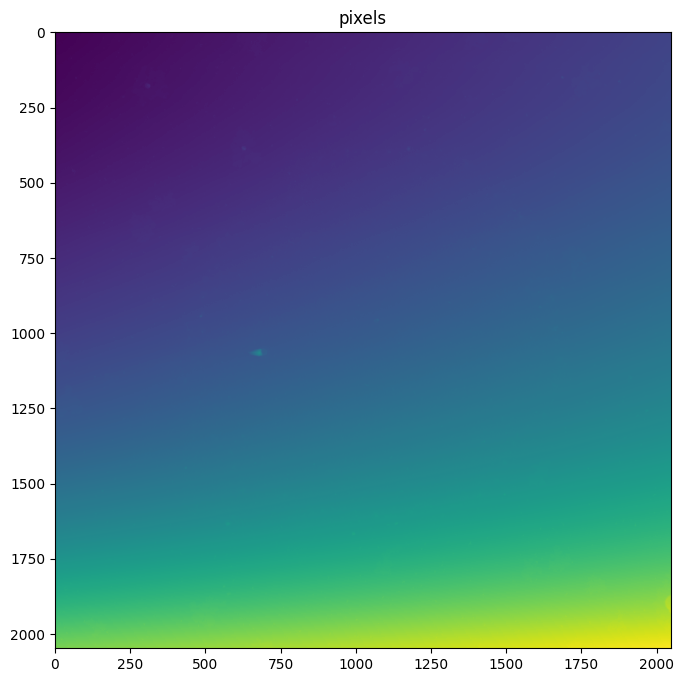

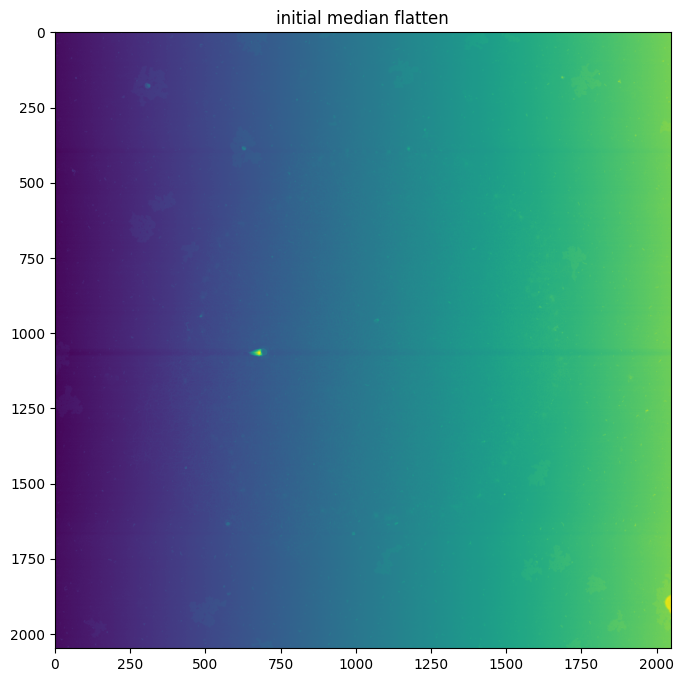

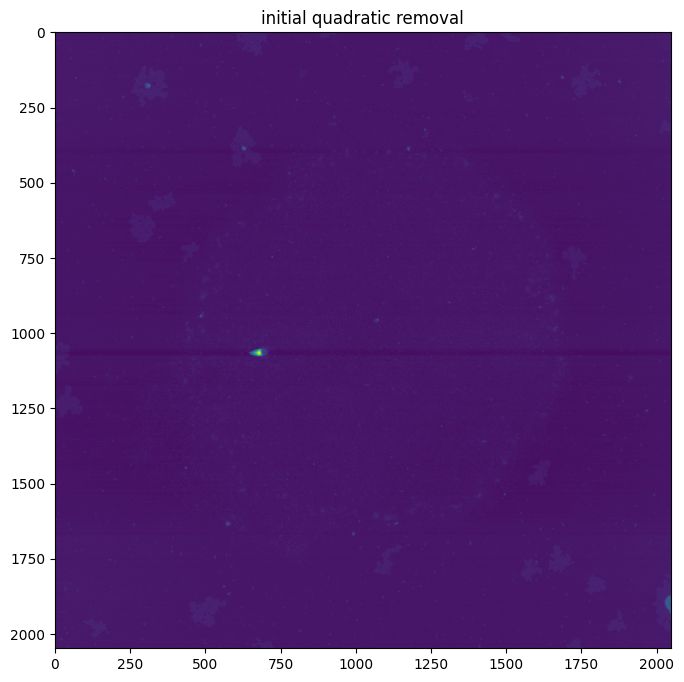

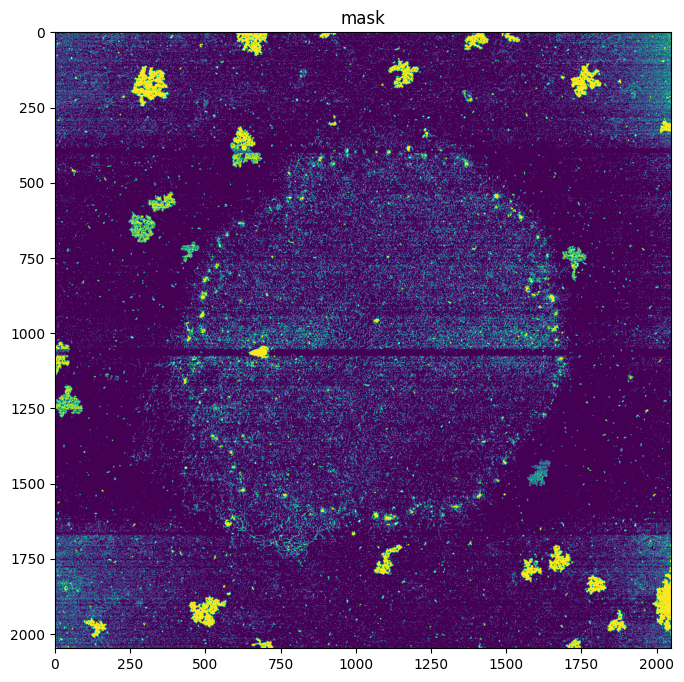

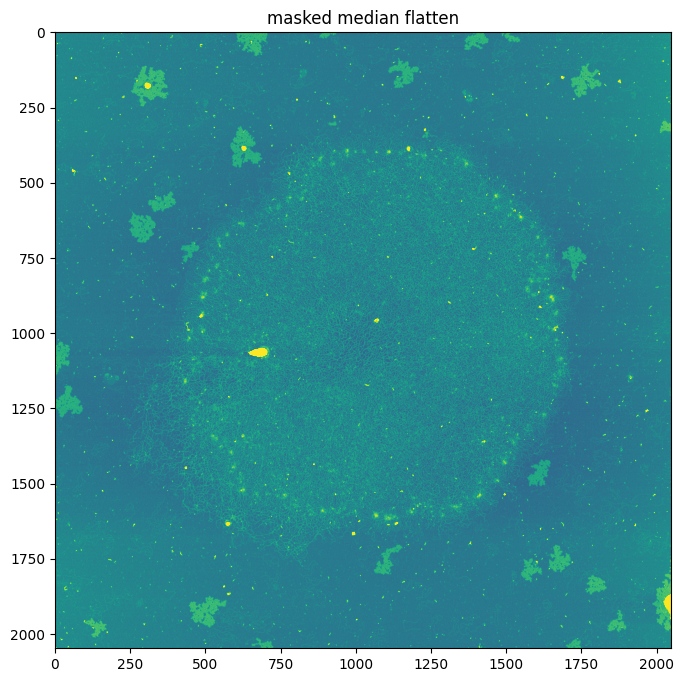

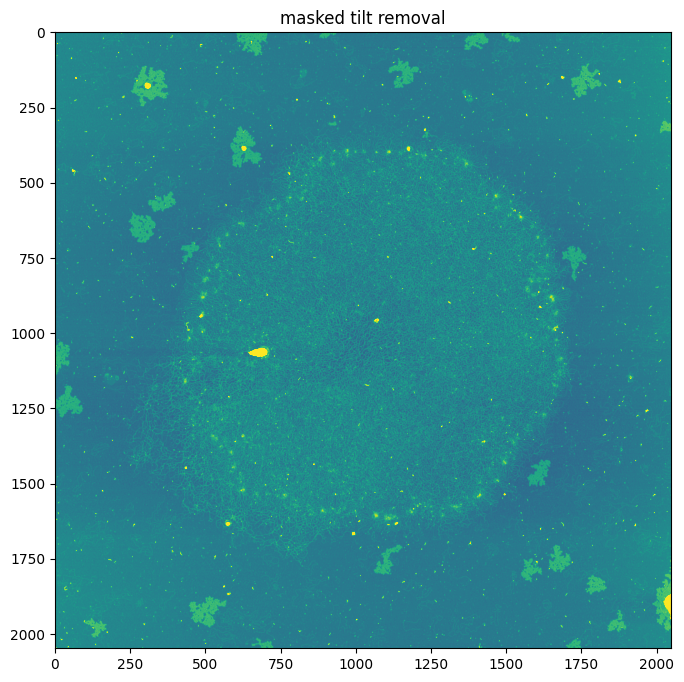

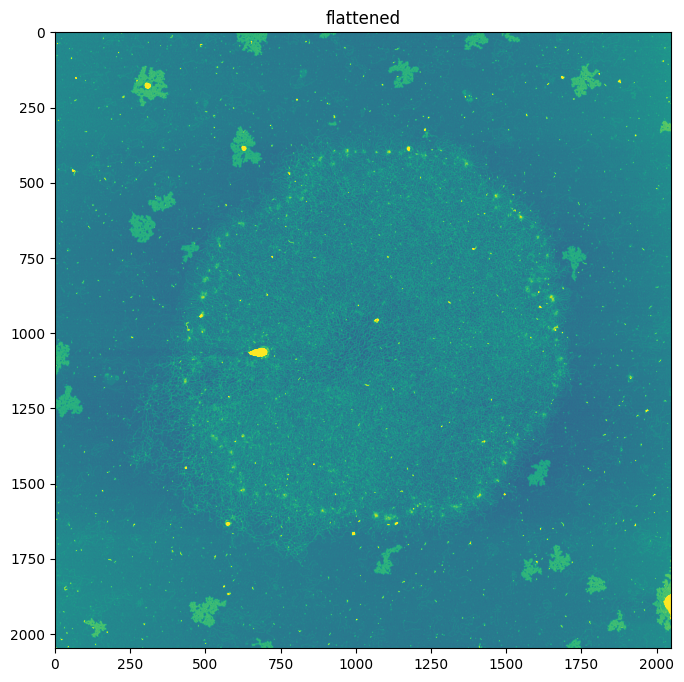

In [10]:
# Flatten the image
filters = topofilters.Filters(
    image = image_raw,
    filename = file,
    pixel_to_nm_scaling = p_to_nm,
    threshold_method='std_dev',
    threshold_std_dev={'upper': 1.0, 'lower': None},
    gaussian_size=1.0,
    remove_scars={'run': False}
)

filters.filter_image()

# Plot the flattened image
plot(filters.images['pixels'], title='pixels', zlimit=False)
plot(filters.images['initial_median_flatten'], zlimit=False, title='initial median flatten')
plot(filters.images['initial_quadratic_removal'], zlimit=False, title='initial quadratic removal')
plot(filters.images['mask'], title='mask', zlimit=False)
plot(filters.images['masked_median_flatten'], title='masked median flatten')
plot(filters.images['masked_tilt_removal'], title='masked tilt removal')

if np.array_equal(filters.images['masked_tilt_removal'], filters.images['masked_median_flatten']):
    print("EQUAL")

flattened = filters.images['zero_average_background']
plot(flattened, title='flattened')

thresholds: defaultdict(None, {'upper': 1.1455519735089794})
[Tue, 12 Dec 2023 20:40:05] [INFO    ] [topostats] [None] : Masking (upper) Threshold: 1.1455519735089794


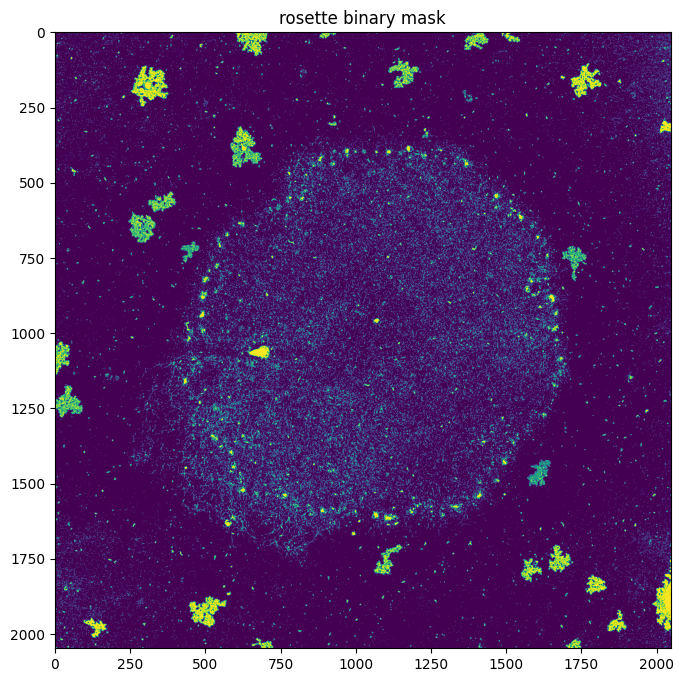

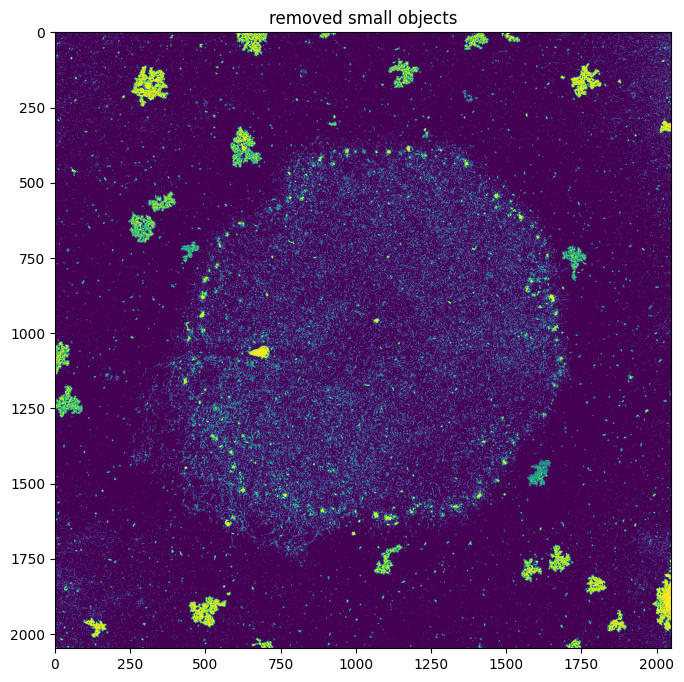

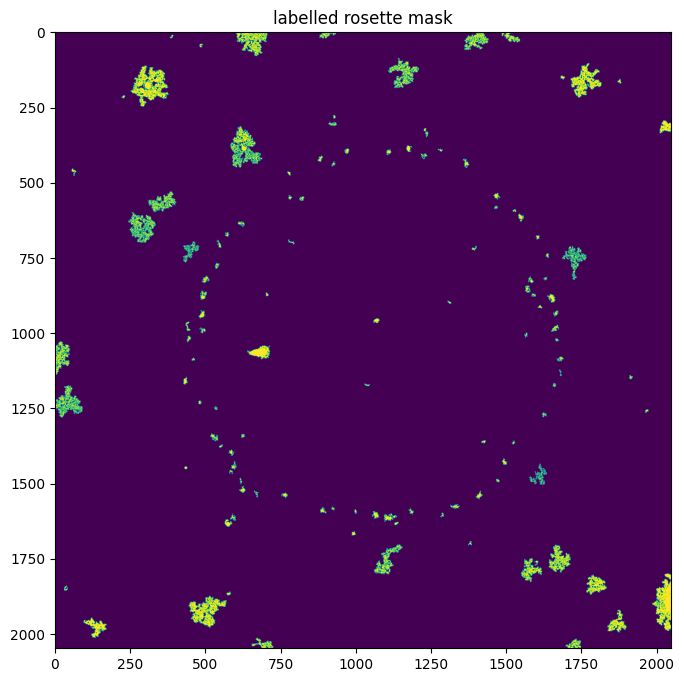

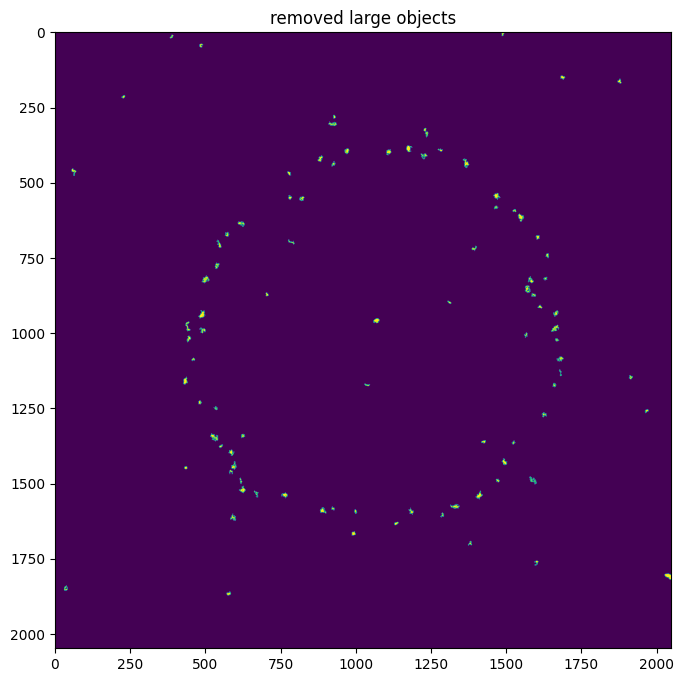

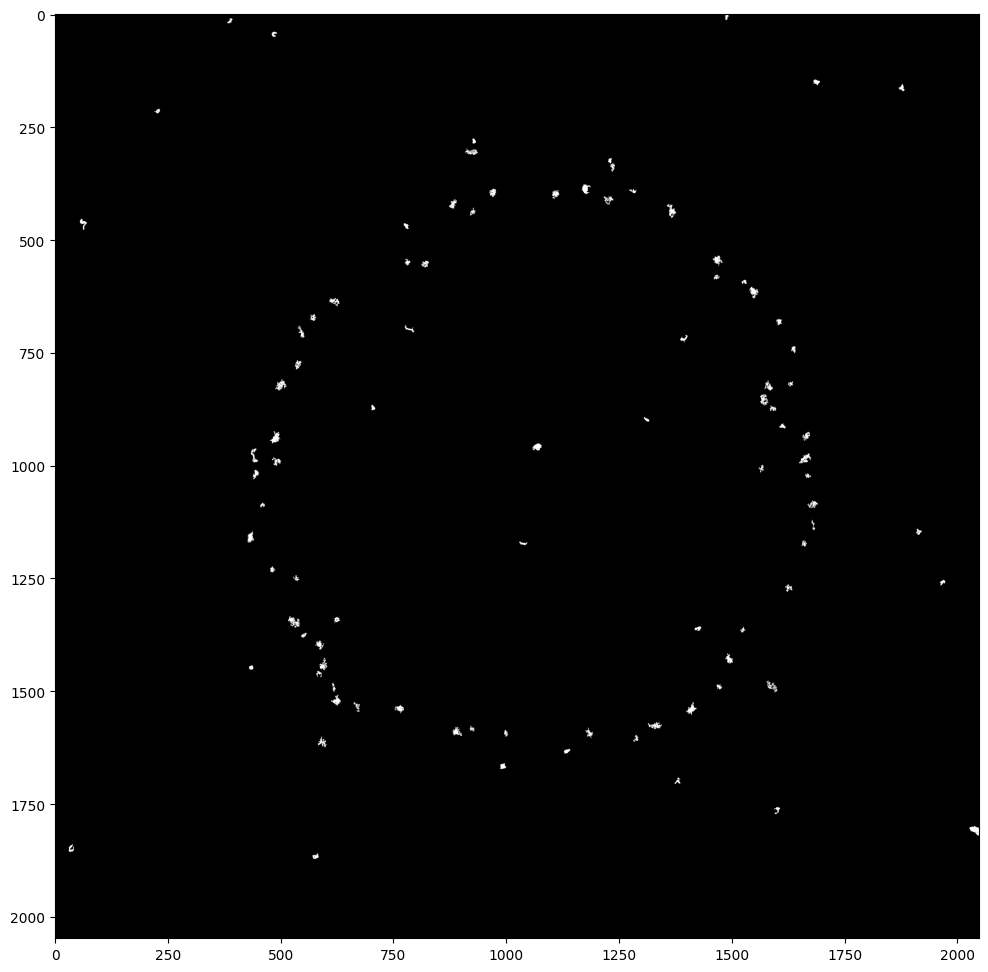

In [11]:
# Thresholding

from skimage.morphology import remove_small_objects, label
from skimage.measure import regionprops

rosette_thresholds = topofilters.get_thresholds(
    flattened,
    threshold_method='std_dev',
    threshold_std_dev={'upper': Rosette_Thres, 'lower': None}
)

print(f'thresholds: {rosette_thresholds}')
rosette_mask = topofilters.get_mask(image=flattened, thresholds=rosette_thresholds)
plot(rosette_mask.astype(bool), title='rosette binary mask', zlimit=False)

# Remove small objects
removed_small_objects = remove_small_objects(rosette_mask, Gauss_Min_Size)
plot(rosette_mask.astype(bool), title='removed small objects', zlimit=False)
# Remove large objects
labelled_rosette_mask = label(removed_small_objects)
plot(labelled_rosette_mask.astype(bool), title='labelled rosette mask', zlimit=False)
regions = regionprops(labelled_rosette_mask)
for props_index, props in enumerate(regions):
    if props.area > Gauss_Max_Size:
        labelled_rosette_mask[labelled_rosette_mask==props.label] = 0

plot(labelled_rosette_mask.astype(bool), title='removed large objects', zlimit=False)
plt.show()

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(labelled_rosette_mask.astype(bool), cmap='gray')


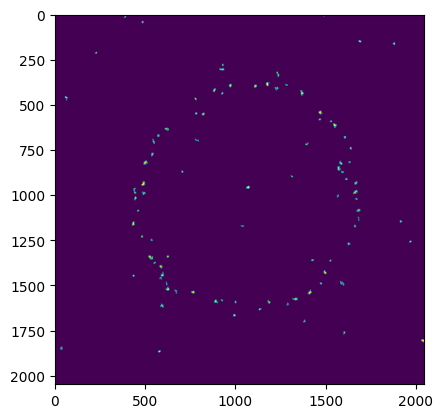

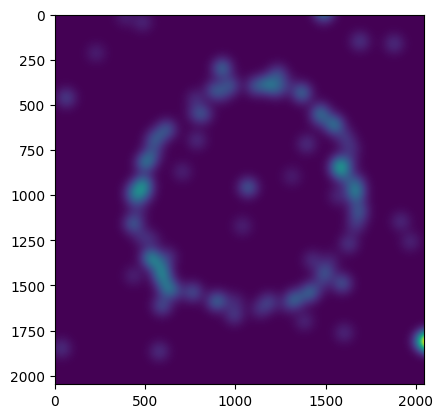

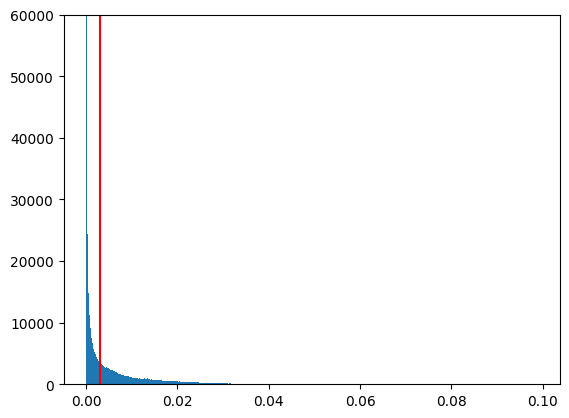

otsu threshold: 0.003


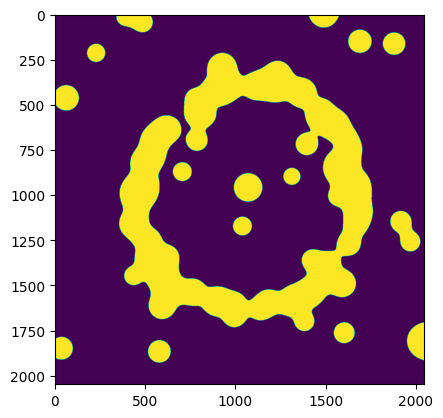

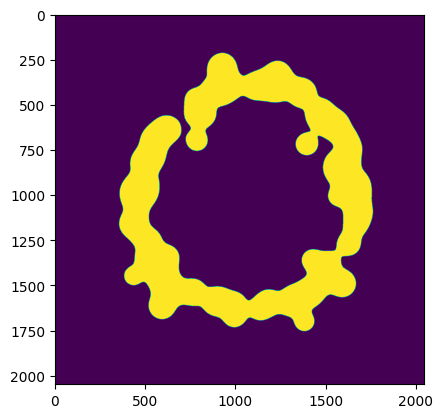

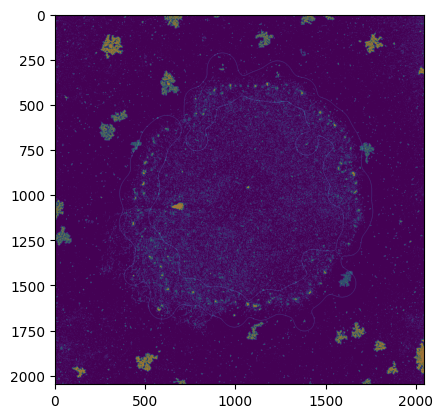

In [12]:
# Get the edge of the structure

plt.imshow(labelled_rosette_mask.astype(bool))
plt.show()
gauss = gaussian(labelled_rosette_mask.astype(bool), Gauss_Sigma)
plt.imshow(gauss)
plt.show()

# threshold = threshold_otsu(gauss)
threshold = Gauss_Thres

fig, ax = plt.subplots()
ax.hist(gauss.flatten(), bins='auto')
ax.set_ylim(0, 60000)
plt.axvline(x=threshold, color='r')
plt.show()

print(f'otsu threshold: {threshold}')
thresholded = gauss > threshold
plt.imshow(thresholded)
plt.show()

labelled = label(thresholded)
region_props = regionprops(labelled)
max_size = max([props.area for props in region_props])
thresholded = remove_small_objects(thresholded, min_size=max_size-1)
thresholded = ndimage.binary_fill_holes(thresholded)
plt.imshow(thresholded)
plt.show()

# Add padding (needed for erosion)
padded = np.pad(thresholded, 1)
# Erode by 1 pixel
eroded = binary_erosion(padded)
# Remove padding
eroded = eroded[1:-1, 1:-1]

# Edges is equal to the difference between the
# original image and the eroded image.
edges = thresholded.astype(int) - eroded.astype(int)
plt.imshow(rosette_mask)
plt.imshow(edges, alpha=0.5)
plt.show()

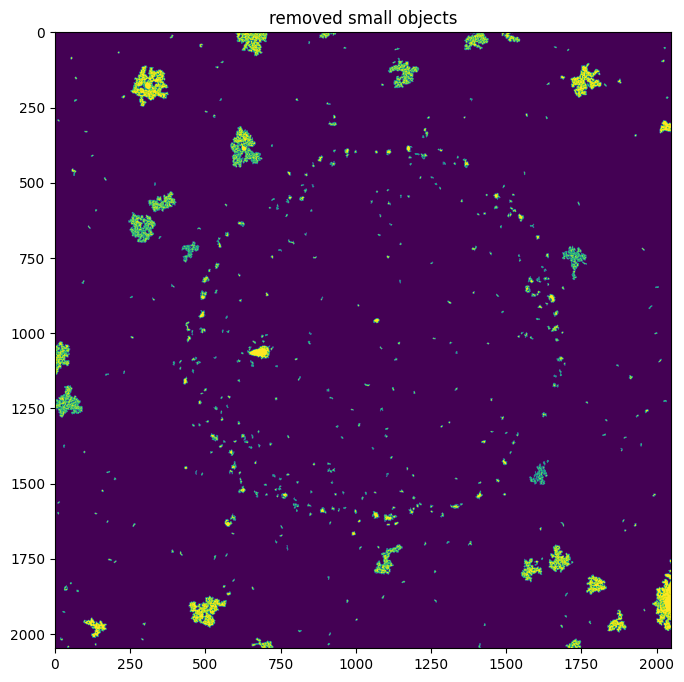

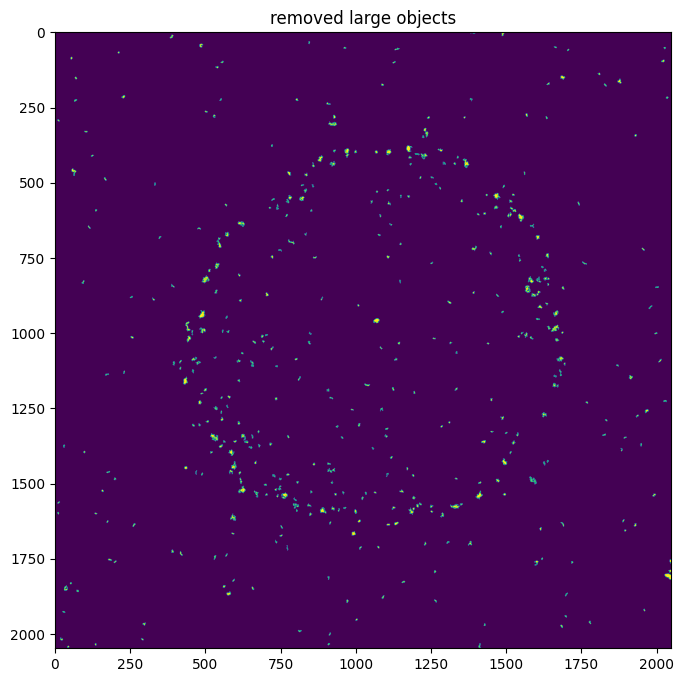

In [13]:
#Second Thresholding
fibril_thres = rosette_mask.copy()
# Remove small objects
fib_removed_small_objects = remove_small_objects(fibril_thres, Fibril_Min_Size)
plot(fib_removed_small_objects.astype(bool), title='removed small objects', zlimit=False)
#Remove large objects
fibril_rosette_mask = label(fib_removed_small_objects)
#plot(fibril_rosette_mask.astype(bool), title='fibril rosette mask', zlimit=False)
regions = regionprops(fibril_rosette_mask)
for props_index, props in enumerate(regions):
    if props.area > Fibril_Max_Size:
        fibril_rosette_mask[fibril_rosette_mask==props.label] = 0

plot(fibril_rosette_mask.astype(bool), title='removed large objects', zlimit=False)
plt.show()


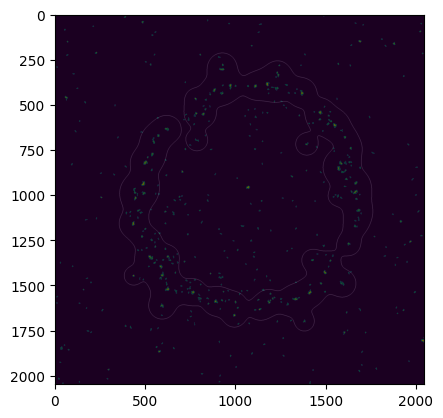

mean distance: 139.26496306927027
std dev distance: 142.11250543484675


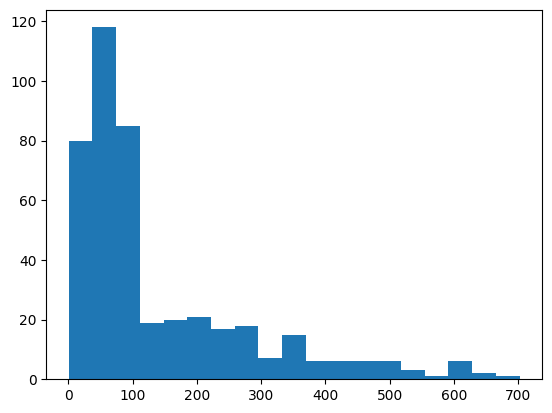

distance threshold: 125.05371252578558
points shape: (291, 2)


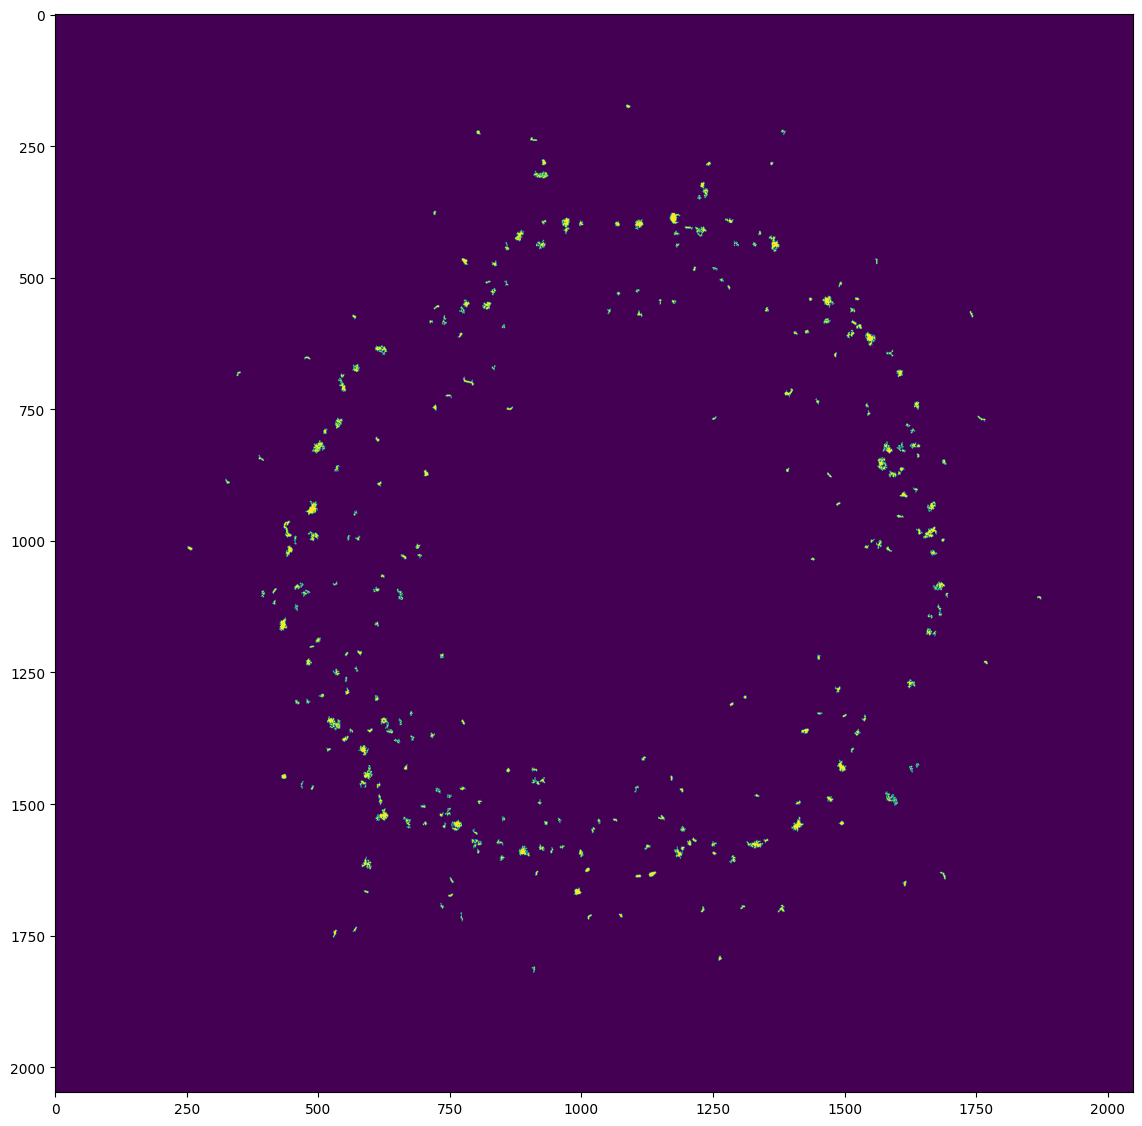

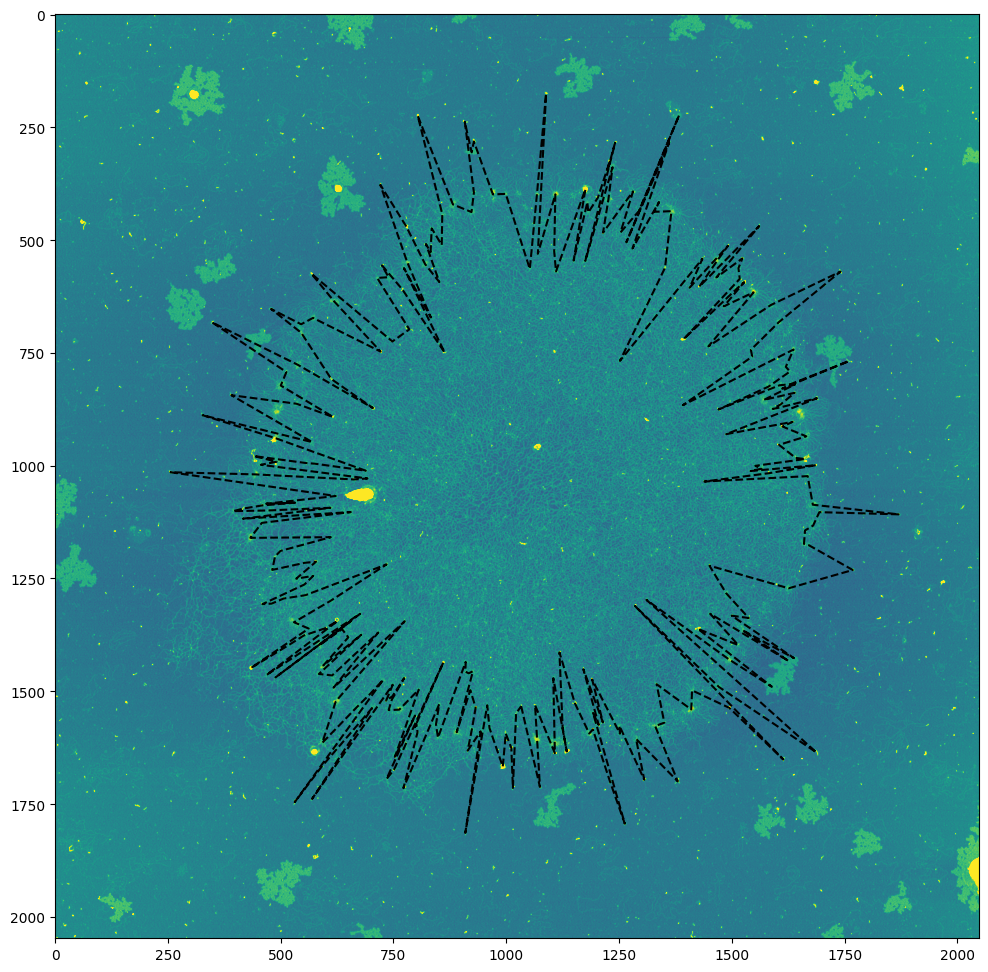

In [14]:
plt.imshow(fibril_rosette_mask.astype(bool))
plt.imshow(edges, alpha=0.6, cmap='gray')
plt.show()

edge_positions = np.transpose(np.nonzero(edges))
region_props = regionprops(fibril_rosette_mask)
min_distances = np.zeros(len(region_props))
for props_index, props in enumerate(region_props):
    proplabel = props['label']
    centroid = np.array(props['centroid']).reshape(-1, 2)
    distances = np.linalg.norm(centroid - edge_positions, axis=1)
    min_distance = np.min(distances)
    min_distances[props_index] = min_distance

print(f'mean distance: {np.mean(min_distances)}')
print(f'std dev distance: {np.std(min_distances)}')
plt.hist(min_distances, bins='auto')
plt.show()
distance_threshold = np.mean(min_distances) - Threshold_Dist * np.std(min_distances)
print(f'distance threshold: {distance_threshold}')

removed_too_far_points = fibril_rosette_mask.copy()
points = np.array([])
for props_index, props in enumerate(region_props):
    proplabel = props['label']
    centroid = np.array(props['centroid']).reshape(-1, 2)
    distances = np.linalg.norm(centroid - edge_positions, axis=1)
    min_distance = np.min(distances)
    if min_distance > distance_threshold:
        removed_too_far_points[removed_too_far_points == proplabel] = 0
    else:
        points = np.append(points, centroid).reshape(-1, 2)

points = np.array(points)
print(f'points shape: {points.shape}')

fig, ax = plt.subplots(figsize=(14, 14))
ax.imshow(removed_too_far_points.astype(bool))
plt.show()

# Find centroids of remaining points
labelled = label(removed_too_far_points)
regions = regionprops(labelled)
points = np.ndarray((len(regions), 2))
for props_index, props in enumerate(regions):
    points[props_index, :] = props.centroid

centroid = np.array([np.mean(points[:, 0]), np.mean(points[:, 1])])

# Function to find angle of point from centroid
def angle(point, centroid):
    dx, dy = point - centroid
    return (np.arctan2(dy, dx) + 2 * np.pi) % (2 * np.pi)

# Sort the points based on their angles around the centroid
sorted = points[np.argsort([angle(point, centroid) for point in points])]

xs = np.append(sorted[:, 1], sorted[0, 1])
ys = np.append(sorted[:, 0], sorted[0, 0])

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(flattened, vmin=-3, vmax=4)
ax.plot(xs, ys, 'k--')

plt.show()


In [15]:
sorted_loop = np.append(sorted, sorted[0, :]).reshape(-1, 2)
import network_stats as ns
global_density_map, molecule_density_map, internal_density_map, near_outline_density_map, dens_internal, dist_internal, dens_noutline, dist_noutline, points_internal = ns.network_density(
    nodes = sorted_loop,
    image = flattened,
    px_to_nm = p_to_nm,
    stepsize_px = int(np.floor(np.sqrt(flattened.size))/40),
    kernel_size = int(np.floor(np.sqrt(flattened.size))/80),
    gaussian_sigma = int(np.floor(np.sqrt(flattened.size))/125)
)
#Correcting for negative heights
dens_correction = min(min(dens_internal),min(dens_noutline))
dens_internal_corr = dens_internal - dens_correction
dens_noutline_corr = dens_noutline - dens_correction
print(len(dens_internal),len(dens_internal_corr))

density map dimensions: (40, 40)


c:\Users\bdigg\miniconda3\envs\git_topo\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\bdigg\miniconda3\envs\git_topo\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


145 145


C:\Users\bdigg\AppData\Local\Temp\ipykernel_26220\692115618.py:2: RuntimeWarning: invalid value encountered in sqrt
  dist_internal = np.sqrt(dist_internal)*p_to_nm*0.001
C:\Users\bdigg\AppData\Local\Temp\ipykernel_26220\692115618.py:3: RuntimeWarning: invalid value encountered in sqrt
  dist_noutline = np.sqrt(dist_noutline)*p_to_nm*0.001


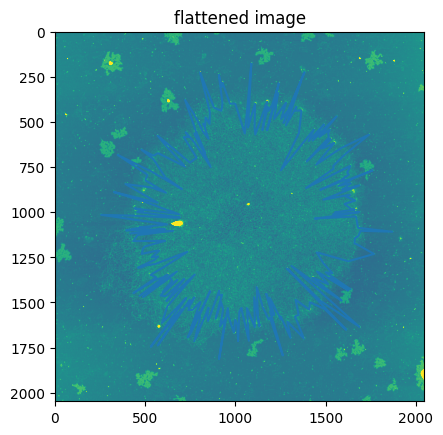

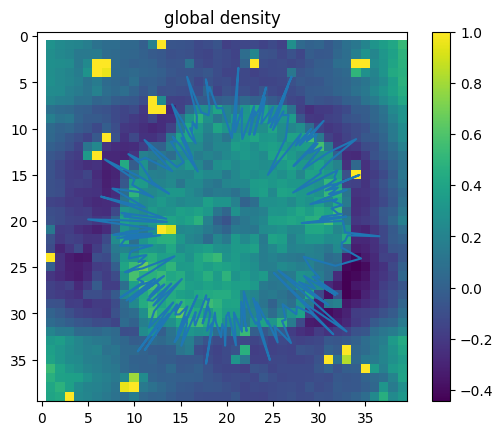

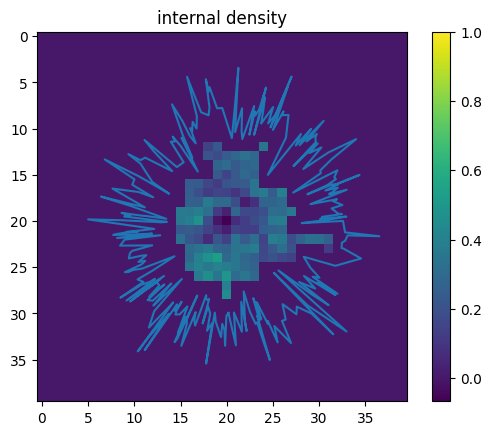

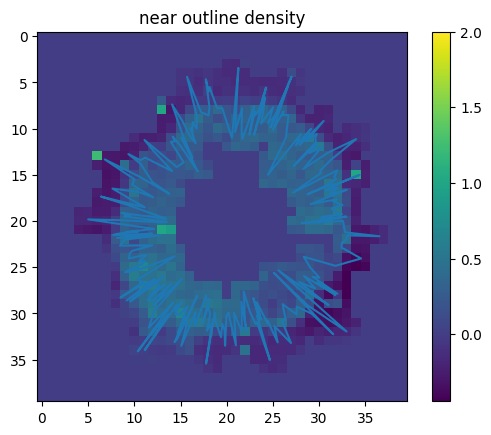

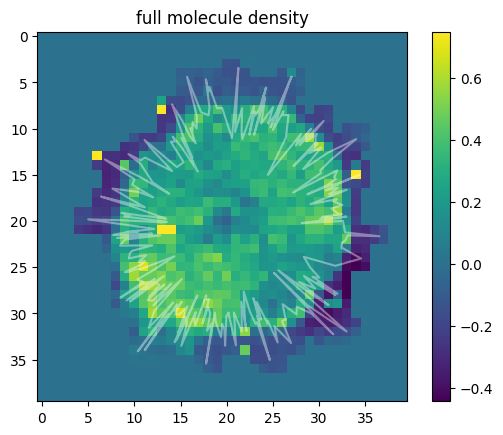

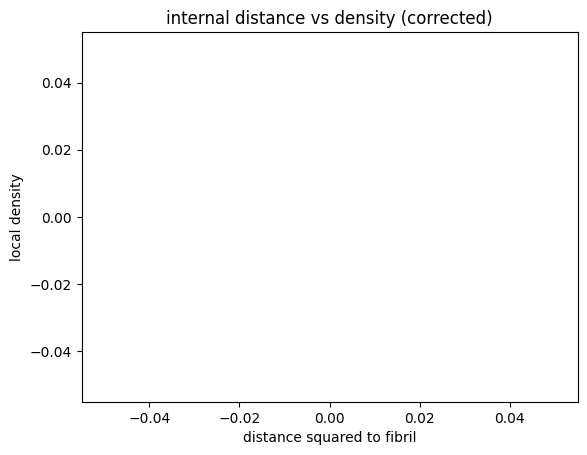

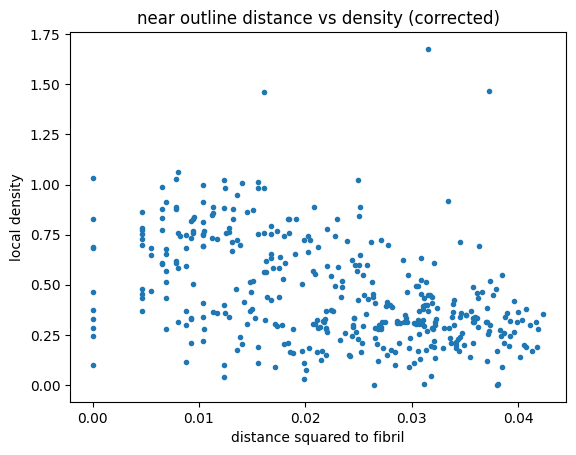

In [16]:
#Apply unit scaling
dist_internal = np.sqrt(dist_internal)*p_to_nm*0.001
dist_noutline = np.sqrt(dist_noutline)*p_to_nm*0.001

scaling_factor = flattened.shape[0] / internal_density_map.shape[0]
plt.imshow(flattened, vmin=-3, vmax=4)
plt.plot(sorted_loop[:, 1], sorted_loop[:, 0])
plt.title('flattened image')
plt.show()
plt.imshow(global_density_map, vmax=1)
plt.plot(sorted_loop[:, 1] / scaling_factor, sorted_loop[:, 0] / scaling_factor)
plt.colorbar()
plt.title('global density')
plt.show()
plt.imshow(internal_density_map, vmax=1)
plt.plot(sorted_loop[:, 1] / scaling_factor, sorted_loop[:, 0] / scaling_factor)
plt.colorbar()
plt.title('internal density')
plt.show()
plt.imshow(near_outline_density_map, vmax=2)
plt.plot(sorted_loop[:, 1] / scaling_factor, sorted_loop[:, 0] / scaling_factor)
plt.colorbar()
plt.title('near outline density')
plt.show()
plt.imshow(molecule_density_map, vmax=0.75)
plt.plot(sorted_loop[:, 1] / scaling_factor, sorted_loop[:, 0] / scaling_factor,'w', alpha=0.4)
plt.colorbar()
plt.title('full molecule density')
plt.show()

plt.scatter(x=dist_internal, y=dens_internal_corr, marker='.')
plt.xlabel('distance squared to fibril')
plt.ylabel('local density')
plt.title('internal distance vs density (corrected)')
plt.show()
plt.scatter(x=dist_noutline, y=dens_noutline_corr, marker='.')
plt.title('near outline distance vs density (corrected)')
plt.xlabel('distance squared to fibril')
plt.ylabel('local density')
plt.show()

Image: EcoPst\20230406_EPN001_BlackTeflon_Standard.0_00005.spm
- molecule stats -
area: 23.02 μm^2
perimeter: 155.02 μm
min_feret: 7.17 μm | max_feret: 8.09 μm
- curvature stats -
min curvature: 6.378335660212199e-10, max curvature: 712353.4365538344, mean curvature: 1.2531718593405239 sum curvature: 1094019.0332042773


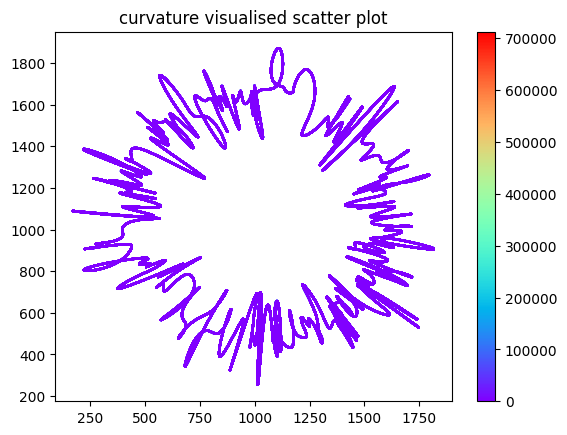

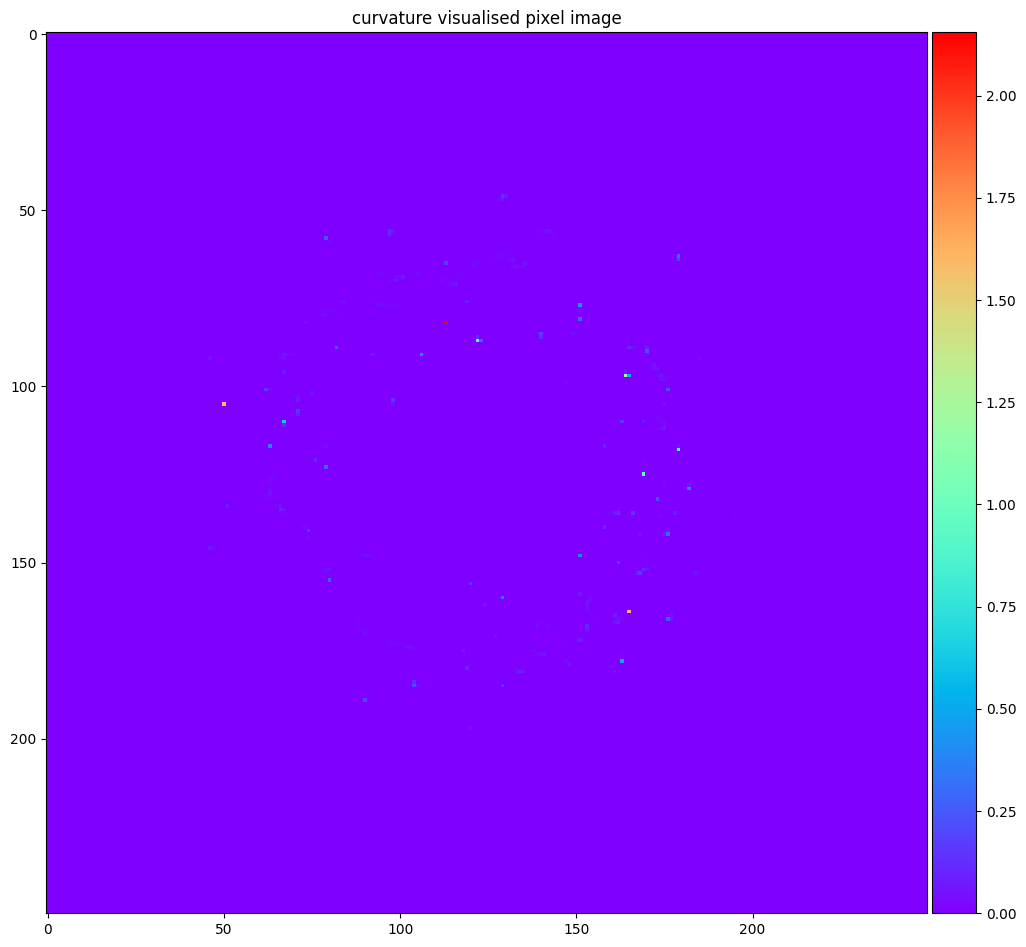

- node stats -
number of nodes in perimeter: 291
node areas | min: 537.93 nm^2 max: 6240.01 nm^2 mean: 1359.43 nm^2
node volumes | min: 796.93 nm^3 max: 23195.37 nm^3 mean: 3041.98 nm^3
mean node height values | min: 1.46 nm max: 5.57 nm mean: 2.25 nm
max node height values | min: 1.99 nm max: 14.99 nm mean: 4.25 nm

Full Curvature Values:
[0.97493604 0.3045787  0.48719411 ... 0.48702008 0.30452408 0.97484889] 

---------------------------------------------------------------


In [17]:

MICRON_SCALING_FACTOR = 0.001
P_TO_MICRON = p_to_nm * MICRON_SCALING_FACTOR

print('Image:',file)

print('- molecule stats -')
area = ns.network_area(sorted) * P_TO_MICRON**2
print(f'area: {area:.2f} μm^2')
perimeter = ns.polygon_perimeter(sorted) * P_TO_MICRON
print(f'perimeter: {perimeter:.2f} μm')
min_feret, max_feret = ns.network_feret_diameters(sorted)
print(f'min_feret: {min_feret* P_TO_MICRON:.2f} μm | max_feret: {max_feret* P_TO_MICRON:.2f} μm')
regionstats = ns.node_stats(labelled_image=labelled, image=flattened)

interpolated_curvatures, interpolated_points = ns.interpolate_spline_and_get_curvature(points=sorted, interpolation_number=3000)
print('- curvature stats -')
print(f'min curvature: {np.min(interpolated_curvatures)}, max curvature: {np.max(interpolated_curvatures)}, mean curvature: {np.mean(interpolated_curvatures)} sum curvature: {np.sum(interpolated_curvatures)}')

ns.visualise_curvature_scatter(curvatures=interpolated_curvatures, points=interpolated_points, title="curvature visualised scatter plot")
ns.visualise_curvature_pixel_image(curvatures=interpolated_curvatures, points=interpolated_points, title="curvature visualised pixel image", image_size=250, figsize=(12, 12))

print('- node stats -')
num_perimeter_nodes = sorted.shape[0]
print(f'number of nodes in perimeter: {num_perimeter_nodes}')
print(f'node areas | min: {np.min(regionstats["node areas"]* p_to_nm**2):.2f} nm^2 max: {np.max(regionstats["node areas"]* p_to_nm**2):.2f} nm^2 mean: {np.mean(regionstats["node areas"]* p_to_nm**2):.2f} nm^2')
print(f'node volumes | min: {np.min(regionstats["node volumes"]* p_to_nm**2):.2f} nm^3 max: {np.max(regionstats["node volumes"]* p_to_nm**2):.2f} nm^3 mean: {np.mean(regionstats["node volumes"]* p_to_nm**2):.2f} nm^3')
print(f'mean node height values | min: {np.min(regionstats["node mean_heights"]):.2f} nm max: {np.max(regionstats["node mean_heights"]):.2f} nm mean: {np.mean(regionstats["node mean_heights"]):.2f} nm')
print(f'max node height values | min: {np.min(regionstats["node max_heights"]):.2f} nm max: {np.max(regionstats["node max_heights"]):.2f} nm mean: {np.mean(regionstats["node max_heights"]):.2f} nm\n')

print('Full Curvature Values:')
print(interpolated_curvatures,"\n")
print("---------------------------------------------------------------")

In [18]:
print(interpolated_points)
print(interpolated_curvatures)

[[1532.96666667 1033.06666667]
 [1532.96610331 1033.07661887]
 [1532.96558832 1033.08657364]
 ...
 [1532.96793849 1033.04676994]
 [1532.9672784  1033.05671702]
 [1532.96666667 1033.06666667]]
[0.97493604 0.3045787  0.48719411 ... 0.48702008 0.30452408 0.97484889]


In [19]:
#Density-Curvature
denscurv = []
for r,row in enumerate(molecule_density_map):
    for c, d_point in enumerate(row):
        if d_point > 0:
            min_dist = np.inf
            for index, c_point in enumerate(interpolated_points):
                dist = np.sqrt((c_point[0]-r)**2+(c_point[1]-c))
                if dist < min_dist:
                    min_dist=dist
                    x = r
                    y = c
                    curv = interpolated_curvatures[index]
            print([x,y,curv])
            denscurv.append([x,y,curv])

print(denscurv)

#For each density point, calcualte nearest fibril/curvature point
#Limit for a given radius/distance to fibril??

[3, 22, 483.36085489687997]
[4, 27, 483.36085489687997]
[6, 18, 483.36085489687997]
[7, 13, 483.36085489687997]
[7, 20, 483.36085489687997]
[7, 22, 483.36085489687997]
[7, 23, 483.36085489687997]
[7, 24, 483.36085489687997]
[8, 13, 483.36085489687997]
[8, 16, 483.36085489687997]
[8, 17, 483.36085489687997]
[8, 18, 483.36085489687997]
[8, 19, 483.36085489687997]
[8, 20, 483.36085489687997]
[8, 21, 483.36085489687997]
[8, 22, 483.36085489687997]
[8, 23, 483.36085489687997]
[8, 24, 483.36085489687997]
[8, 25, 483.36085489687997]
[8, 26, 483.36085489687997]
[8, 27, 483.36085489687997]
[9, 15, 483.36085489687997]
[9, 16, 483.36085489687997]
[9, 17, 483.36085489687997]
[9, 18, 483.36085489687997]
[9, 19, 483.36085489687997]
[9, 20, 483.36085489687997]
[9, 21, 483.36085489687997]
[9, 22, 483.36085489687997]
[9, 23, 483.36085489687997]
[9, 24, 483.36085489687997]
[9, 25, 483.36085489687997]
[9, 26, 483.36085489687997]
[9, 27, 483.36085489687997]
[10, 15, 483.36085489687997]
[10, 16, 483.360854

In [ ]:
"""header = "KDNA001"
with open('density.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    for stat in data: 
        writer.writerow(np.transpose(stat))"""


'header = "KDNA001"\nwith open(\'density.csv\', \'w\', encoding=\'UTF8\') as f:\n    writer = csv.writer(f)\n    writer.writerow(header)\n    for stat in data: \n        writer.writerow(np.transpose(stat))'

In [ ]:
#Node Seperation
for k,x in enumerate(xs):
    if k>0:
        dist = np.sqrt((xs[k-1]-xs[k])**2 + (ys[k-1]-ys[k])**2)*p_to_nm
        print(dist)


143.36884554101317
125.52061031054727
162.63961770621353
111.61175854561753
601.1278417968857
165.17329424886017
175.46132260753785
185.9386571335285
234.01721817384356
266.3220746067181
275.392065411867
205.34165200534486
185.65724233831932
342.04051087785024
442.42878312888786
332.33050025451416
338.10620792498645
340.86084875236725
372.00521362397274
195.61237601107544
516.033377614278
372.31176852635116
268.3942841589242
363.77451016693914
305.8458547846528
834.6905075684954
376.03523115901135
328.90080478003836
192.52140310078585
186.00331238748385
328.2864578926502
89.47677967554635
351.64816623584915
771.3163497669374
392.05891013909735
183.66954581740242
136.82274664715217
250.37023523461875
321.311303400637
332.8000004864352
375.43202594682214
344.82413929603285
73.73385773604274
160.50890988231984
179.27919344190886
205.5188809518201
185.48297557872095
178.72885745980636
113.23776136005361
386.23356910596345
139.47820556246955
207.301966104087
137.66197636821843
267.508830187

In [ ]:
print('Correction: +',-dens_correction)
data = [dist_internal,dens_internal_corr,dist_noutline,dens_noutline_corr]
data_names = ['dist_internal','dens_internal_corr','dist_noutline','dens_noutline_corr']
for count,params in enumerate(data):
    print(data_names[count],"----------------------------------------------------------")
    for i,stat in enumerate(params):
        print(stat)

Correction: + 0.27462750981756623
dist_internal ----------------------------------------------------------
0.41600017320189175
0.39367491674070476
0.45360830033123795
0.472450816267158
0.5508917343486222
0.5883130868916719
0.6758236545312142
0.6542798535248626
0.5988745241115896
0.5417593750000002
0.5092504886357806
0.4580780201466819
0.4593308465095457
0.5206387379475909
0.634785844612581
0.7323101351930379
0.7925908992147629
0.8393304744464322
0.9236101847011495
0.9143865711951545
0.8421268004984024
0.8024171875000001
0.7648155515629882
0.69256503467254
0.5759960804721143
0.4594445704148559
0.5190055742603169
0.676210060311516
0.7763916130450152
0.8571302759064624
0.9925882755986779
1.0378601467768085
1.0948625452062501
1.1676674699589737
1.1740147177662374
1.093358432055685
1.063075
1.020397103905241
0.9257006979789795
0.8091438938031394
0.6889157006485609
0.5212154009050626
0.3804130899353237
0.6369015636499766
0.8821957817563134
1.0345956546381738
1.09648371700862
1.21245614566814

In [ ]:
MICRON_SCALING_FACTOR = 0.001
P_TO_MICRON = p_to_nm * MICRON_SCALING_FACTOR

print('Image:',file)

print('- molecule stats -')
area = ns.network_area(sorted)* P_TO_MICRON**2
print(f'area: {area:.2f} μm^2')
perimeter = ns.polygon_perimeter(sorted)* P_TO_MICRON
print(f'perimeter: {perimeter:.2f} μm')
min_feret, max_feret = ns.network_feret_diameters(sorted)
print(f'min_feret: {min_feret* P_TO_MICRON:.2f} μm | max_feret: {max_feret* P_TO_MICRON:.2f} μm')
regionstats = ns.node_stats(labelled_image=labelled, image=flattened)
interp_curvatures, interpolated_points = ns.interpolate_spline_and_get_curvature(sorted,3000)
print(f'mean_curvature: {np.mean(interp_curvatures)}')

print('- node stats -')
num_perimeter_nodes = sorted.shape[0]
print(f'number of nodes in perimeter: {num_perimeter_nodes}')
print(f'node areas | min: {np.min(regionstats["node areas"]* p_to_nm**2):.2f} nm^2 max: {np.max(regionstats["node areas"]* p_to_nm**2):.2f} nm^2 mean: {np.mean(regionstats["node areas"]* p_to_nm**2):.2f} nm^2')
print(f'node volumes | min: {np.min(regionstats["node volumes"]* p_to_nm**2):.2f} nm^3 max: {np.max(regionstats["node volumes"]* p_to_nm**2):.2f} nm^3 mean: {np.mean(regionstats["node volumes"]* p_to_nm**2):.2f} nm^3')
print(f'mean node height values | min: {np.min(regionstats["node mean_heights"]):.2f} nm max: {np.max(regionstats["node mean_heights"]):.2f} nm mean: {np.mean(regionstats["node mean_heights"]):.2f} nm')
print(f'max node height values | min: {np.min(regionstats["node max_heights"]):.2f} nm max: {np.max(regionstats["node max_heights"]):.2f} nm mean: {np.mean(regionstats["node max_heights"]):.2f} nm\n')

print('Full Curvature Values:')
"""for p in interp_curvatures:
    print(p)"""

print("\n---------------------------------------------------------------")

Image: flat\20230126_KPN005.0_00013.spm
- molecule stats -
area: 39.08 μm^2
perimeter: 23.52 μm
min_feret: 6.86 μm | max_feret: 7.52 μm


c:\Users\bdigg\OneDrive\Documents\GitHub\Topostats-Tutorial\TopoStats\Bradley\network_stats.py:317: RuntimeWarning: invalid value encountered in double_scalars
  return np.linalg.norm(np.cross(a_b, a_c)) / np.linalg.norm(a_b)


mean_curvature: 0.01378765467939056
- node stats -
number of nodes in perimeter: 89
node areas | min: 653.04 nm^2 max: 7836.50 nm^2 mean: 2194.51 nm^2
node volumes | min: 1375.72 nm^3 max: 20608.88 nm^3 mean: 5339.13 nm^3
mean node height values | min: 2.03 nm max: 2.95 nm mean: 2.38 nm
max node height values | min: 2.70 nm max: 5.66 nm mean: 4.04 nm

Full Curvature Values:

---------------------------------------------------------------
